# Immorthon

In [1]:
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install bitsandbytes

In [2]:
import pandas as pd

# cloner si on est sur colab
if 'google.colab' in str(get_ipython()):
  !git clone https://github.com/sully-vian/immorthon.git
  dicoPath = "immorthon/dico-c.csv"
else:
  dicoPath = "dico-c.csv"

df = pd.read_csv(dicoPath)
df["text"] = "Define: " + df["word"] + "\n" + df["definition"]

fatal: destination path 'immorthon' already exists and is not an empty directory.


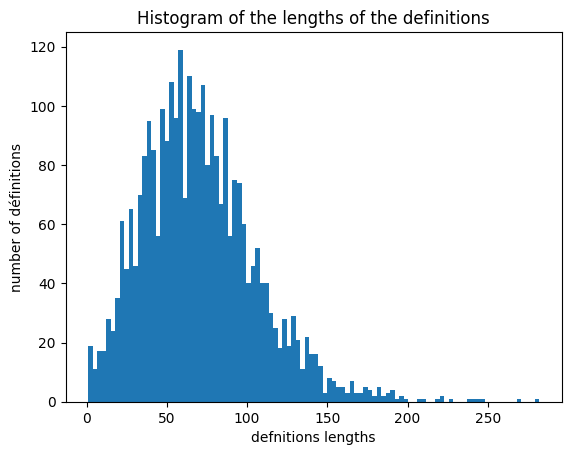

In [3]:
import matplotlib.pyplot as plt

definition_lengths = [len(definition) for definition in df["definition"]]
plt.hist(definition_lengths, bins=100)
plt.title('Histogram of the lengths of the definitions')
plt.xlabel('defnitions lengths')
plt.ylabel('number of définitions')
plt.show()

In [6]:
from datasets import Dataset

dataset = Dataset.from_pandas(df[["text"]])
# séparer aléatoirement la data en train et test
splitDataset = dataset.train_test_split(test_size=0.1)

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

modelName = "databricks/dolly-v2-3b"
tokenizer = AutoTokenizer.from_pretrained(modelName)
model = AutoModelForCausalLM.from_pretrained(modelName)

def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenizedDataset = splitDataset.map(tokenize, batched=True)

In [10]:
from transformers import TrainingArguments, Trainer

trainingArgs = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="no",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=trainingArgs,
    train_dataset=tokenizedDataset["train"],
    eval_dataset=tokenizedDataset["test"],
    tokenizer=tokenizer
)

trainer.train()

NameError: name 'model' is not defined

In [2]:
from transformers import pipeline

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

prompt = "Define: blorptastic"
results = generator(prompt, max_length=50, num_return_sequences=3, do_sample=True, temperature=0.7)

for i, result in enumerate(results):
    print(f"Result {i+1}: {result['generated_text']}")

NameError: name 'model' is not defined